In [1]:
import pandas as pd
import numpy as np
import json

In [2]:
import sys, os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

from helper.plots import feature_plots
from helper.utils import data_tools

In [3]:
from sklearn.dummy import DummyRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, make_scorer
from sklearn.model_selection import KFold, train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.inspection import permutation_importance
from scipy.stats import randint, uniform, norm


import xgboost as xgb
from catboost import CatBoostRegressor

In [4]:
SEED = 42

### 5. Обучение моделей

In [5]:
train = pd.read_csv('./data/train_pred.csv', index_col=0)
test = pd.read_csv('./data/test_pred.csv', index_col=0)

In [6]:
train.head(5)

,MSZoning,LotArea,Alley,LotShape,LandContour,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,...,GarageFinish,GarageCars,GarageQual,GarageCond,PavedDrive,WoodDeckSF,ScreenPorch,SaleType,SaleCondition,SalePrice
0,RL,8450,NoAlley,Reg,Lvl,Inside,Gtl,CollgCr,Norm,Norm,...,RFn,2,TA,TA,Y,0,0,WD,Normal,208500
1,RL,9600,NoAlley,Reg,Lvl,FR2,Gtl,Veenker,Feedr,Norm,...,RFn,2,TA,TA,Y,298,0,WD,Normal,181500
2,RL,11250,NoAlley,IR1,Lvl,Inside,Gtl,CollgCr,Norm,Norm,...,RFn,2,TA,TA,Y,0,0,WD,Normal,223500
3,RL,9550,NoAlley,IR1,Lvl,Corner,Gtl,Crawfor,Norm,Norm,...,Unf,3,TA,TA,Y,0,0,WD,Abnorml,140000
4,RL,14260,NoAlley,IR1,Lvl,FR2,Gtl,NoRidge,Norm,Norm,...,RFn,3,TA,TA,Y,192,0,WD,Normal,250000


Целевая переменная в этом датасете распределена асимметрично — большинство домов стоят в диапазоне 100–250 тыс, но есть редкие дорогие дома за 600–700 тыс. Поэтому прологарифмируем её.

In [7]:
X, y = train.drop(columns=['SalePrice']), train['SalePrice']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=SEED)

In [8]:
forest_params = {
    'reg__n_estimators' : randint(20, 700),
    'reg__max_depth' : randint(3, 20),
    'reg__min_samples_split': randint(2, 10),
    'reg__min_samples_leaf': randint(1, 4)
}

In [9]:
forest = RandomForestRegressor(n_jobs=-1)

In [10]:
forest_model = data_tools.PipelineManager(train, forest).train_model(forest_params)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Лучшие параметры модели: {'reg__max_depth': 13, 'reg__min_samples_leaf': 2, 'reg__min_samples_split': 6, 'reg__n_estimators': 276}
MAE модели: 16021.98


##### 5.2. XGBoost

In [11]:
xgb_params = {
    'reg__n_estimators' : randint(100, 1000),
    'reg__max_depth' : randint(3, 12),
    'reg__learning_rate' : uniform(0.01, 0.3)
}

In [12]:
xgb_model = xgb.XGBRegressor(random_state=SEED, n_jobs=-1)

In [13]:
xgb_pipe = data_tools.PipelineManager(train, xgb_model).train_model(xgb_params)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Лучшие параметры модели: {'reg__learning_rate': 0.0635389504856014, 'reg__max_depth': 4, 'reg__n_estimators': 797}
MAE модели: 14183.41


#### 5.3 Catboost

In [14]:
cat_params = {
    'reg__n_estimators' : randint(100, 1000),
    'reg__max_depth' : randint(3, 12),
    'reg__learning_rate' : uniform(0.01, 0.3)
}

In [15]:
cat_model = CatBoostRegressor()

In [16]:
cat_pipe = data_tools.PipelineManager(train, cat_model).train_model(cat_params)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
0:	learn: 0.3875167	total: 85ms	remaining: 1m 5s
1:	learn: 0.3761697	total: 86.2ms	remaining: 33.2s
2:	learn: 0.3667657	total: 87.1ms	remaining: 22.3s
3:	learn: 0.3562684	total: 88.2ms	remaining: 16.9s
4:	learn: 0.3467313	total: 89.2ms	remaining: 13.7s
5:	learn: 0.3379693	total: 90.5ms	remaining: 11.6s
6:	learn: 0.3284933	total: 91.6ms	remaining: 10s
7:	learn: 0.3196566	total: 92.7ms	remaining: 8.85s
8:	learn: 0.3116149	total: 93.7ms	remaining: 7.94s
9:	learn: 0.3047233	total: 94.7ms	remaining: 7.21s
10:	learn: 0.2973708	total: 95.6ms	remaining: 6.61s
11:	learn: 0.2907073	total: 96.6ms	remaining: 6.12s
12:	learn: 0.2837732	total: 97.5ms	remaining: 5.7s
13:	learn: 0.2781711	total: 98.6ms	remaining: 5.34s
14:	learn: 0.2722161	total: 99.7ms	remaining: 5.03s
15:	learn: 0.2661729	total: 101ms	remaining: 4.76s
16:	learn: 0.2601029	total: 102ms	remaining: 4.52s
17:	learn: 0.2546792	total: 103ms	remaining: 4.3s
18:	learn: 0.2501680	t

##### 5.4. Итоговая оценка на тестовой выборке

In [17]:
X_test = test
test_id = test['Id']

In [18]:
drop_columns = [col for col in X_test.columns if col not in X_train.columns]

In [19]:
X_test = X_test.drop(columns=drop_columns)

In [20]:
test_predict = np.expm1(cat_pipe.predict(X_test))

In [21]:
submission = pd.DataFrame({
    'Id': test_id,          
    'SalePrice': test_predict
})

In [22]:
submission.to_csv('predict.csv', index=False)

Оценка на Kaggle.

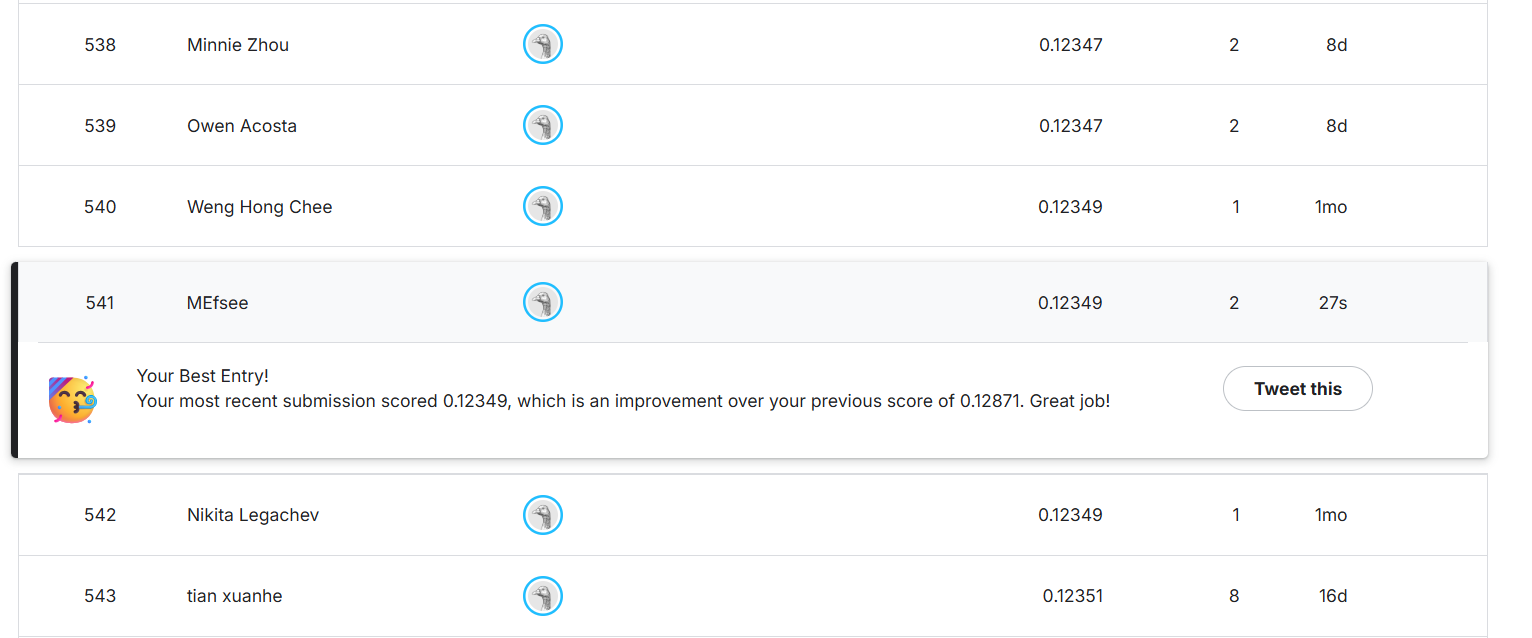

#### 6. Вывод 

In [28]:
error = round(13346.11 / y_train.mean(), 2) * 100
print(f'Итоговая ошибка модели в процентах: {error}%')

Итоговая ошибка модели в процентах: 7.000000000000001%


После обучения модели CatBoost с использованием регрессии для предсказания цен домов на основе датасета House Prices, была получена средняя абсолютная ошибка (MAE) на валидационном наборе данных:

MAE = 13346.11 долларов.

Это означает, что в среднем модель ошибается на 13346 доллар при предсказаниях цены домов.

Относительная ошибка составляет 7%

Это означает, что ошибка модели составляет около 7% от средней цены дома, что является отличным результатом для регрессионных моделей.